分别对低保真度训练数据与高保真度训练数据建立神经网络进行特征提取，将低保真度数据特征与高保真度数据特征分别使用高斯过程进行预测。然后输入高保真度测试数据X，分别通过训练好的两个神经网络和高斯过程，再将两个正态分布相加，取出均值除以二，进行结果的预测

In [2]:
import torch
import math
import numpy as np
import gpytorch
import torch.nn as nn
from gpytorch.kernels import RBFKernel, ScaleKernel
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [3]:
XTest = np.loadtxt('./dataset/x_test_high.txt').reshape(-1,32)
# XTest = XTest.mean(axis=1).reshape(-1)
YTest = np.loadtxt('./dataset/y_test_high.txt').reshape(-1)

XLow = np.loadtxt('./dataset/x_train_low.txt').reshape(-1,32)
# XLow = XLow.mean(axis=1).reshape(-1)
YLow = (np.loadtxt('./dataset/y_train_low.txt')*1e4).reshape(-1)

XHigh = np.loadtxt('./dataset/x_train_high.txt').reshape(-1,32)
# XHigh = XHigh.mean(axis=1).reshape(-1)
YHigh = np.loadtxt('./dataset/y_train_high.txt').reshape(-1)

XLow = torch.from_numpy(XLow).float()
YLow = torch.from_numpy(YLow).float()
XHigh = torch.from_numpy(XHigh).float()
YHigh = torch.from_numpy(YHigh).float()
XTest = torch.from_numpy(XTest).float()
YTest = torch.from_numpy(YTest).float()

print(XTest.shape)

torch.Size([9, 32])


In [4]:
class LowFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(LowFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(32, 500))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(500, 50))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(50, 2))
        
class HighFeatureExtractor(torch.nn.Sequential):
    def __init__(self):
        super(HighFeatureExtractor, self).__init__()
        self.add_module('linear1', torch.nn.Linear(32, 500))
        self.add_module('relu1', torch.nn.ReLU())
        self.add_module('linear2', torch.nn.Linear(500, 50))
        self.add_module('relu2', torch.nn.ReLU())
        self.add_module('linear3', torch.nn.Linear(50, 2))

featureExtractorLow = LowFeatureExtractor()
featureExtractorHigh = HighFeatureExtractor()

In [5]:
class LowGPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(LowGPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
            self.feature_extractor = featureExtractorLow

        def forward(self, train_x):
            # We're first putting our data through a deep net (feature extractor)
            # We're also scaling the features so that they're nice values
            projected_x = self.feature_extractor(train_x)
            projected_x = projected_x - projected_x.min(0)[0]
            projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [6]:
likelihoodLow=gpytorch.likelihoods.GaussianLikelihood()
modelLow=LowGPRegressionModel(XLow,YLow,likelihoodLow)

In [7]:
class HighGPRegressionModel(gpytorch.models.ExactGP):
        def __init__(self, train_x, train_y, likelihood):
            super(HighGPRegressionModel, self).__init__(train_x, train_y, likelihood)
            self.mean_module = gpytorch.means.ConstantMean()
            self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
            self.feature_extractor = featureExtractorHigh

        def forward(self, train_x):
            # We're first putting our data through a deep net (feature extractor)
            # We're also scaling the features so that they're nice values
#             LowMean=self.modelLow.mean
#             x=torch.stack(train_x,LowMean)
            projected_x = self.feature_extractor(x_train)
            projected_x = projected_x - projected_x.min(0)[0]
            projected_x = 2 * (projected_x / projected_x.max(0)[0]) - 1

            mean_x = self.mean_module(projected_x)
            covar_x = self.covar_module(projected_x)
            return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [8]:
likelihoodHigh=gpytorch.likelihoods.GaussianLikelihood()
modelHigh=LowGPRegressionModel(XHigh,YHigh,likelihoodHigh)

In [9]:
modelHigh.train()
likelihoodHigh.train()
modelLow.train()
likelihoodLow.train()

optimizerLow=torch.optim.Adam([
    {'params':modelLow.mean_module.parameters()},
    {'params':modelLow.covar_module.parameters()},
    {'params':modelLow.feature_extractor.parameters()},
    {'params':modelLow.likelihood.parameters()},
],lr=0.01)
optimizerHigh=torch.optim.SGD([
    {'params':modelHigh.mean_module.parameters()},
    {'params':modelHigh.covar_module.parameters()},
    {'params':modelHigh.feature_extractor.parameters()},
    {'params':modelHigh.likelihood.parameters()},
],lr=0.01)

mllLow=gpytorch.mlls.ExactMarginalLogLikelihood(likelihoodLow,modelLow)
mllHigh=gpytorch.mlls.ExactMarginalLogLikelihood(likelihoodHigh,modelHigh)

for t in range(1000):
    optimizerLow.zero_grad()    
    outputLow=modelLow(XLow)    
    lossLow=-mllLow(outputLow,YLow)    
    if t%10==0:
        print("Epoch",t,"LossLow:",lossLow.item())  
    lossLow.backward()
    optimizerLow.step()


for t in range(3000):
    optimizerHigh.zero_grad()
    outputHigh=modelHigh(XHigh)   
    lossHigh=-mllHigh(outputHigh,YHigh)
    if t%10==0:
        print("Epoch",t,"LossHigh:",lossHigh.item())   
    lossHigh.backward()
    optimizerHigh.step()


Epoch 0 LossLow: 10.281410217285156
Epoch 10 LossLow: 3.2677767276763916
Epoch 20 LossLow: 2.512575387954712
Epoch 30 LossLow: 2.1410915851593018
Epoch 40 LossLow: 1.9278260469436646
Epoch 50 LossLow: 1.7838828563690186
Epoch 60 LossLow: 1.676425814628601
Epoch 70 LossLow: 1.5927467346191406
Epoch 80 LossLow: 1.5197761058807373
Epoch 90 LossLow: 1.4382776021957397
Epoch 100 LossLow: 1.3724088668823242
Epoch 110 LossLow: 1.3190059661865234
Epoch 120 LossLow: 1.262407660484314
Epoch 130 LossLow: 1.2254501581192017
Epoch 140 LossLow: 1.178896188735962
Epoch 150 LossLow: 1.1489821672439575
Epoch 160 LossLow: 1.0974420309066772
Epoch 170 LossLow: 1.0636768341064453
Epoch 180 LossLow: 1.0292953252792358
Epoch 190 LossLow: 1.0120775699615479
Epoch 200 LossLow: 0.9494389891624451
Epoch 210 LossLow: 0.920555830001831
Epoch 220 LossLow: 0.8863676190376282
Epoch 230 LossLow: 0.8335289359092712
Epoch 240 LossLow: 0.7931657433509827
Epoch 250 LossLow: 0.7412766218185425
Epoch 260 LossLow: 0.7197385

Epoch 1130 LossHigh: 2.8256289958953857
Epoch 1140 LossHigh: 2.8079099655151367
Epoch 1150 LossHigh: 2.7901546955108643
Epoch 1160 LossHigh: 2.7723653316497803
Epoch 1170 LossHigh: 2.7545506954193115
Epoch 1180 LossHigh: 2.736710786819458
Epoch 1190 LossHigh: 2.718851327896118
Epoch 1200 LossHigh: 2.7009730339050293
Epoch 1210 LossHigh: 2.683077812194824
Epoch 1220 LossHigh: 2.6651647090911865
Epoch 1230 LossHigh: 2.6472370624542236
Epoch 1240 LossHigh: 2.6292924880981445
Epoch 1250 LossHigh: 2.6113288402557373
Epoch 1260 LossHigh: 2.593348979949951
Epoch 1270 LossHigh: 2.5753490924835205
Epoch 1280 LossHigh: 2.557326555252075
Epoch 1290 LossHigh: 2.5392818450927734
Epoch 1300 LossHigh: 2.5212268829345703
Epoch 1310 LossHigh: 2.503143310546875
Epoch 1320 LossHigh: 2.4850306510925293
Epoch 1330 LossHigh: 2.4668822288513184
Epoch 1340 LossHigh: 2.4486985206604004
Epoch 1350 LossHigh: 2.4304745197296143
Epoch 1360 LossHigh: 2.412208080291748
Epoch 1370 LossHigh: 2.393895387649536
Epoch 13

In [10]:
modelLow.eval()
likelihoodLow.eval()
modelHigh.eval()
likelihoodHigh.eval()
''' Predict at test points '''
# sample f_1 at xtest
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predLow = likelihoodLow(modelLow(XTest))
    predHigh=likelihoodHigh(modelHigh(XTest))
    
    pred=predLow+predHigh
    print(XTest.shape)

torch.Size([9, 32])


r2 score -3.2244657432256068


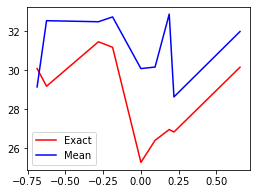

In [11]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    # Get upper and lower confidence bounds
    lower, upper = pred.confidence_region()
    
    X=np.array(XTest).mean(axis=1).reshape(-1)
    YTest=np.array(YTest).reshape(-1)
    lower=lower.numpy().reshape(-1)
    upper=upper.numpy().reshape(-1)
    mean=((pred.mean-3)/2).numpy().reshape(-1)
    
    zipped = zip(X,YTest, mean,lower,upper)
    sort_zipped = sorted(zipped, key=lambda x: (x[0], x[1],x[2],x[3]))
    result = zip(*sort_zipped)
    X,YTest,mean,lower,upper = [list(x) for x in result]
    
    lowerlist=((np.array(lower)-3)/2).tolist() 
    upperlist=((np.array(upper)-3)/2).tolist()
    
    # Plot predictive means as blue line
    ax.plot(X,YTest,'r')
    ax.plot(X,mean,'b')
    # Shade between the lower and upper confidence bounds
#     ax.fill_between(X,lowerlist,upperlist, alpha=0.5)
#     ax.set_ylim([-3, 3])
    ax.legend([ 'Exact','Mean'])
    print("r2 score",r2_score(mean,YTest))